# 1. Description

Play with fair/unfair coin using Bayes theorem and Monte-Carlo Markov Chain.

__Goal:__   
* Investigate [`PyMC`](https://www.pymc.io/welcome.html) library
* To play with `Bayes theorem`, `Monte-Carlo Markov Chain`, prior and posterior distribution

__Plan:__   
* Create coin model in PyMC.
* Plot prior distribution.
* Play with posterior distribution depending on coin heads number in an experiment.   

Coin model consists of head-tails probability distribution and heads ("success") number distribution in experiment series.

# 2. Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

import pymc as pm
import arviz as az

C:\Users\parshin_sa2\AppData\Roaming\Python\Python310\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Custom

In [17]:
from model import coin_model 
from plot_funcs import plot_prior, plot_prior_predictive

# 3. Constants

Visual params

In [2]:
# Matplotlib params
rcParams['figure.figsize'] = 24, 8
plt.set_loglevel('WARNING')

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

rcParams['font.size'] = SMALL_SIZE          # controls default text sizes
rcParams['axes.titlesize'] = SMALL_SIZE     # fontsize of the axes title
rcParams['axes.labelsize'] = MEDIUM_SIZE    # fontsize of the x and y labels
rcParams['xtick.labelsize'] = SMALL_SIZE    # fontsize of the tick labels
rcParams['ytick.labelsize'] = SMALL_SIZE    # fontsize of the tick labels
rcParams['legend.fontsize'] = SMALL_SIZE    # legend fontsize
rcParams['figure.titlesize'] = BIGGER_SIZE  # fontsize of the figure title

sns.set_theme()
BASE_CONTEXT = 'fivethirtyeight'

# Plot
SHOW_ROWS = 600

# See palette
PALETTE = sns.color_palette()
print(PALETTE.as_hex())

['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']


In [11]:
SEED = 42
SAMPLES = 1000

# 4. Create coin model

* Let's assume [beta](https://en.wikipedia.org/wiki/Beta_distribution) distribution for head probability distribution `x` because it's limit from 0 to 1, which corresponds to probability range.
* Let's assume [binominal](https://en.wikipedia.org/wiki/Binomial_distribution) distribution for heads number `k` in a series of experiment because it is fit for "success" distribution tasks in a sequence of a number of independent random experiments with a constant probability of "success".

In [3]:
a = 2   # beta distribution parameter, reflecting our confidence in the coin correctness
b = 2   # beta distribution parameter, reflecting our confidence in the coin correctness
n = 250 # number of experiments - throws

In [6]:
model1, trace1 = coin_model(a, b, n, SEED)

Sampling: [k, x]


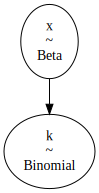

In [14]:
pm.model_to_graphviz(model1)

# 5. Explore model

### Prior

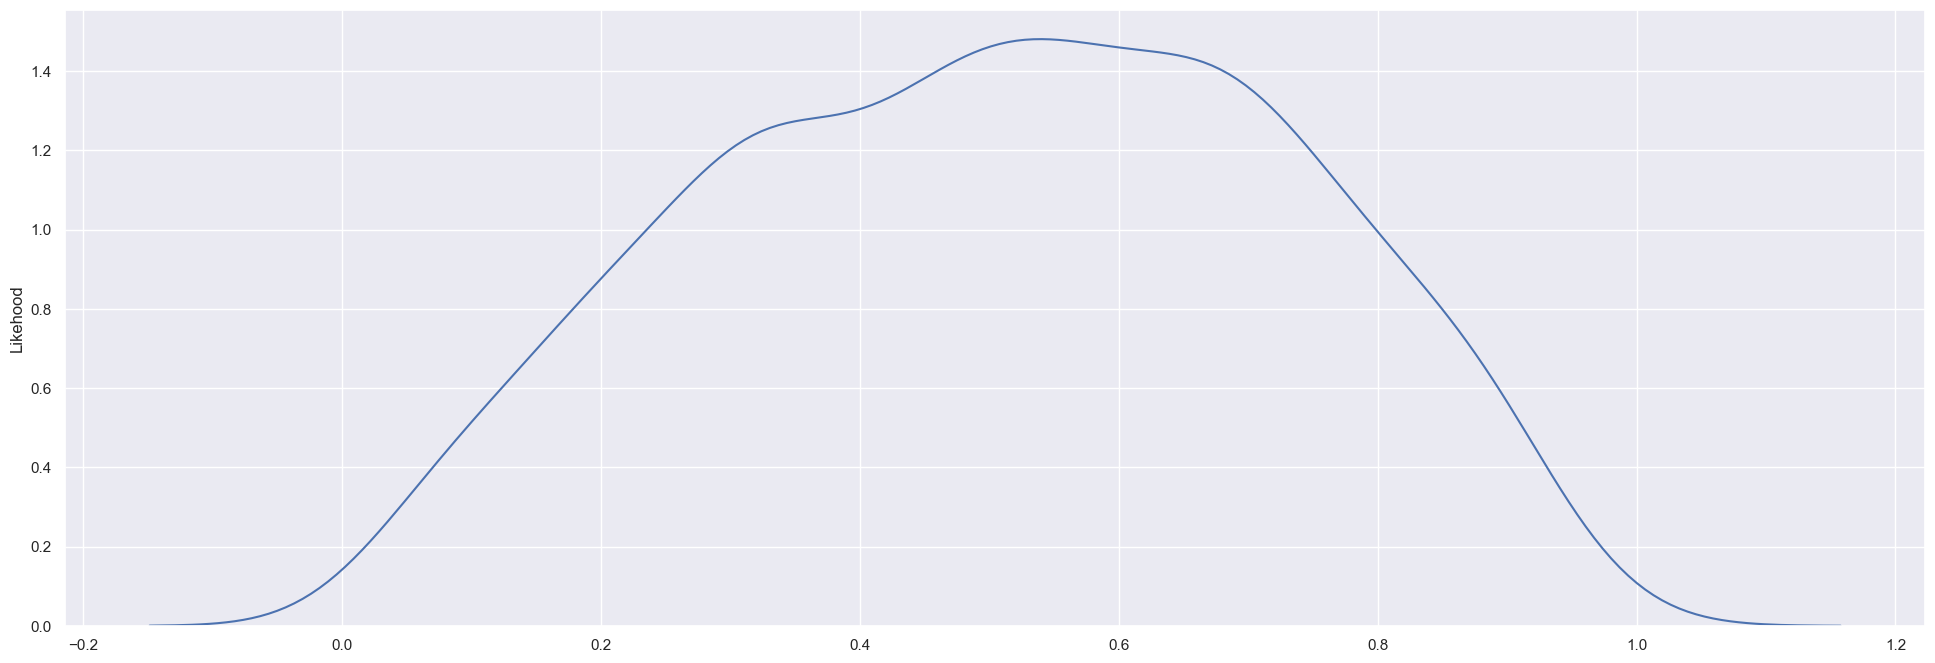

In [15]:
plot_prior(trace1)

### Prior predictive

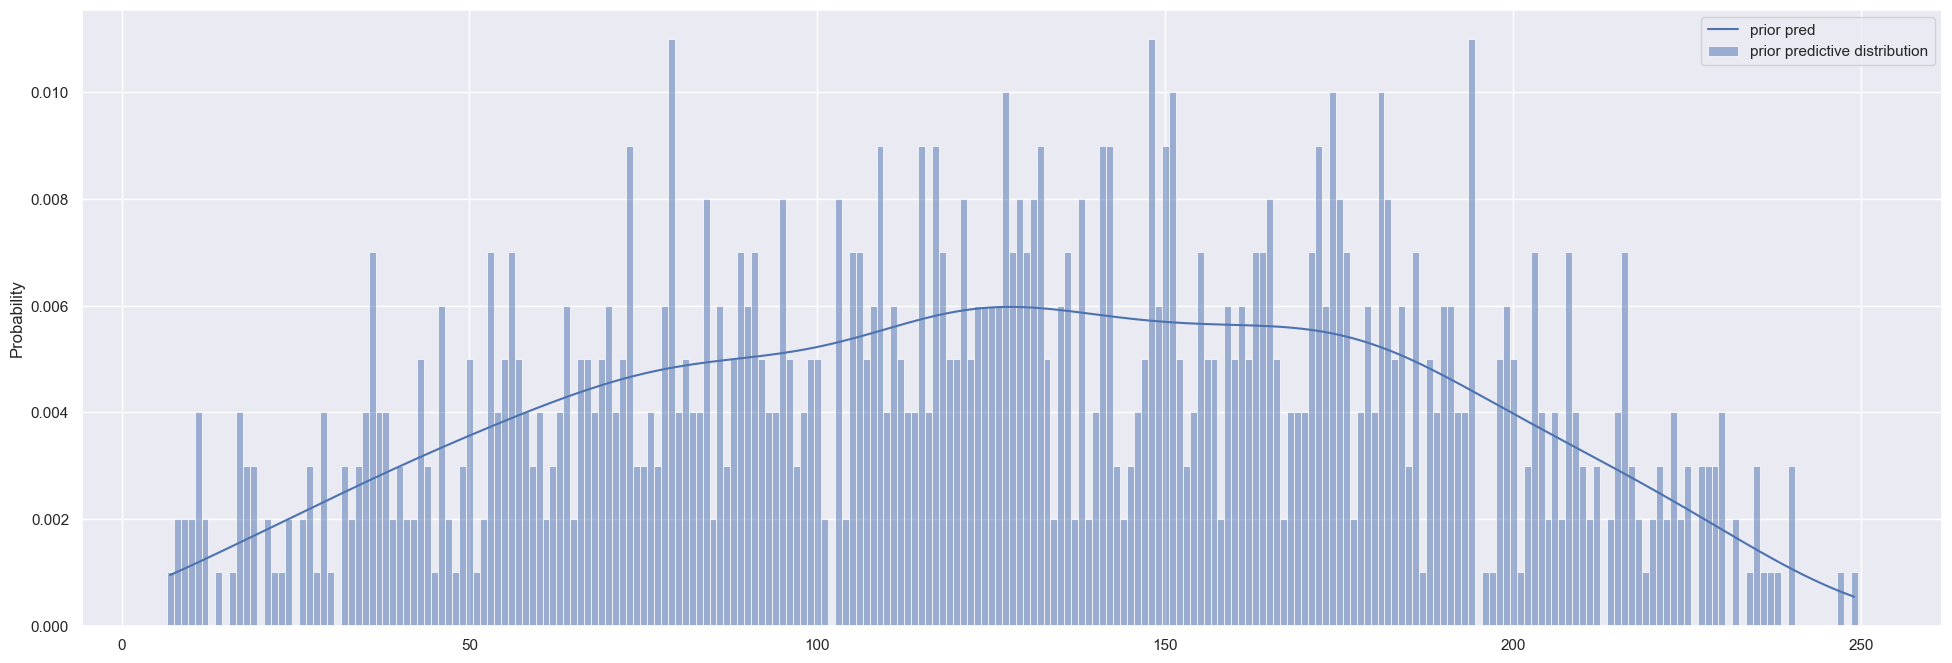

In [18]:
plot_prior_predictive(trace1)

Since we know nothing about the coin and let's assume we are not sure of its validity, the distribution is wide. Being more confident in the coin (e.g. `a` and `b` = 100), the distributions will narrow down and became closer to the dair coin distribution.

In [19]:
model2, trace2 = coin_model(100, 100, n, SEED)

Sampling: [k, x]


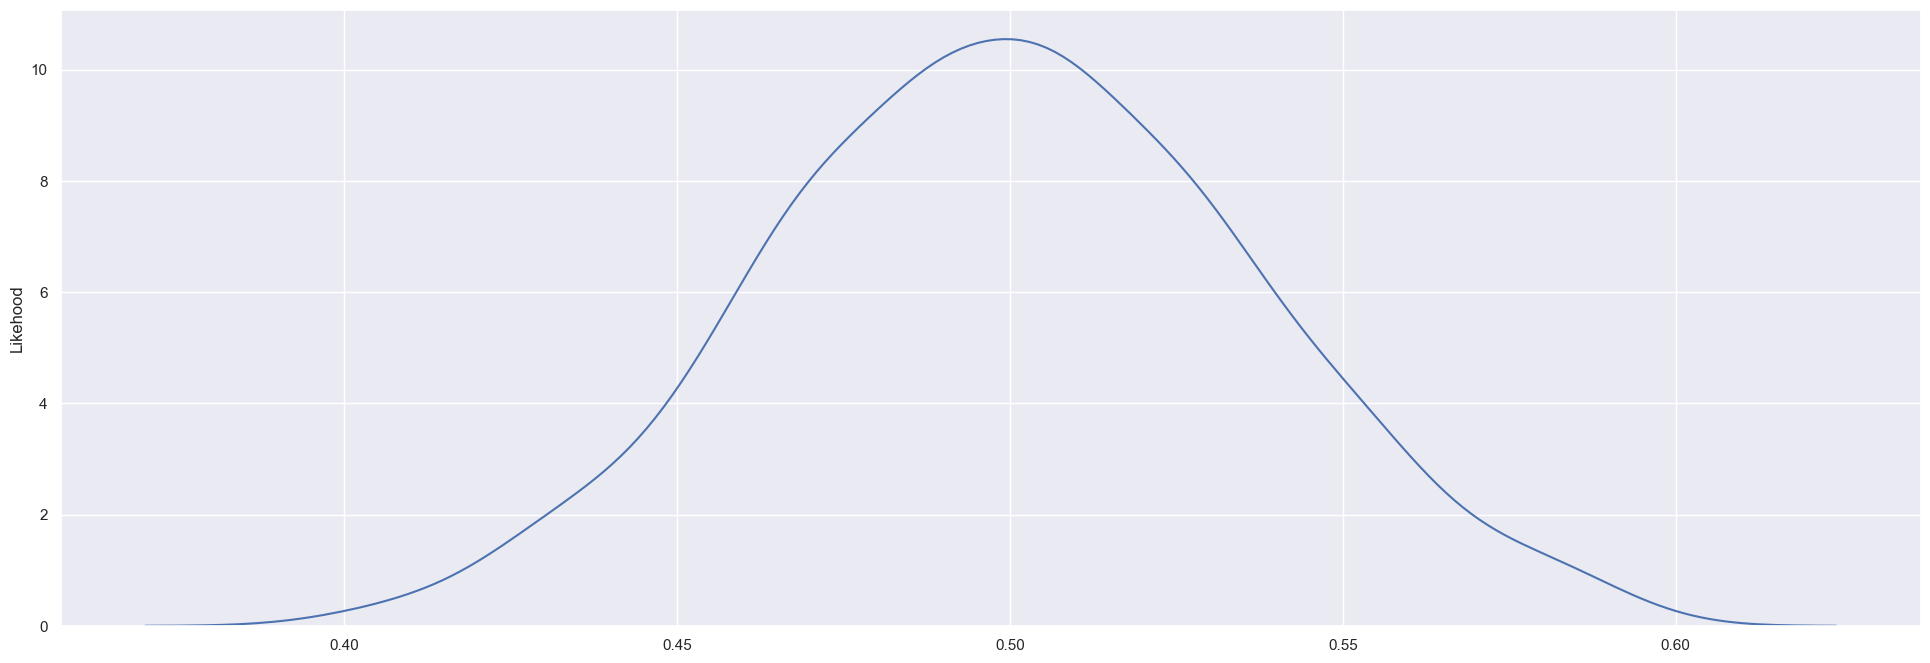

In [20]:
plot_prior(trace2)

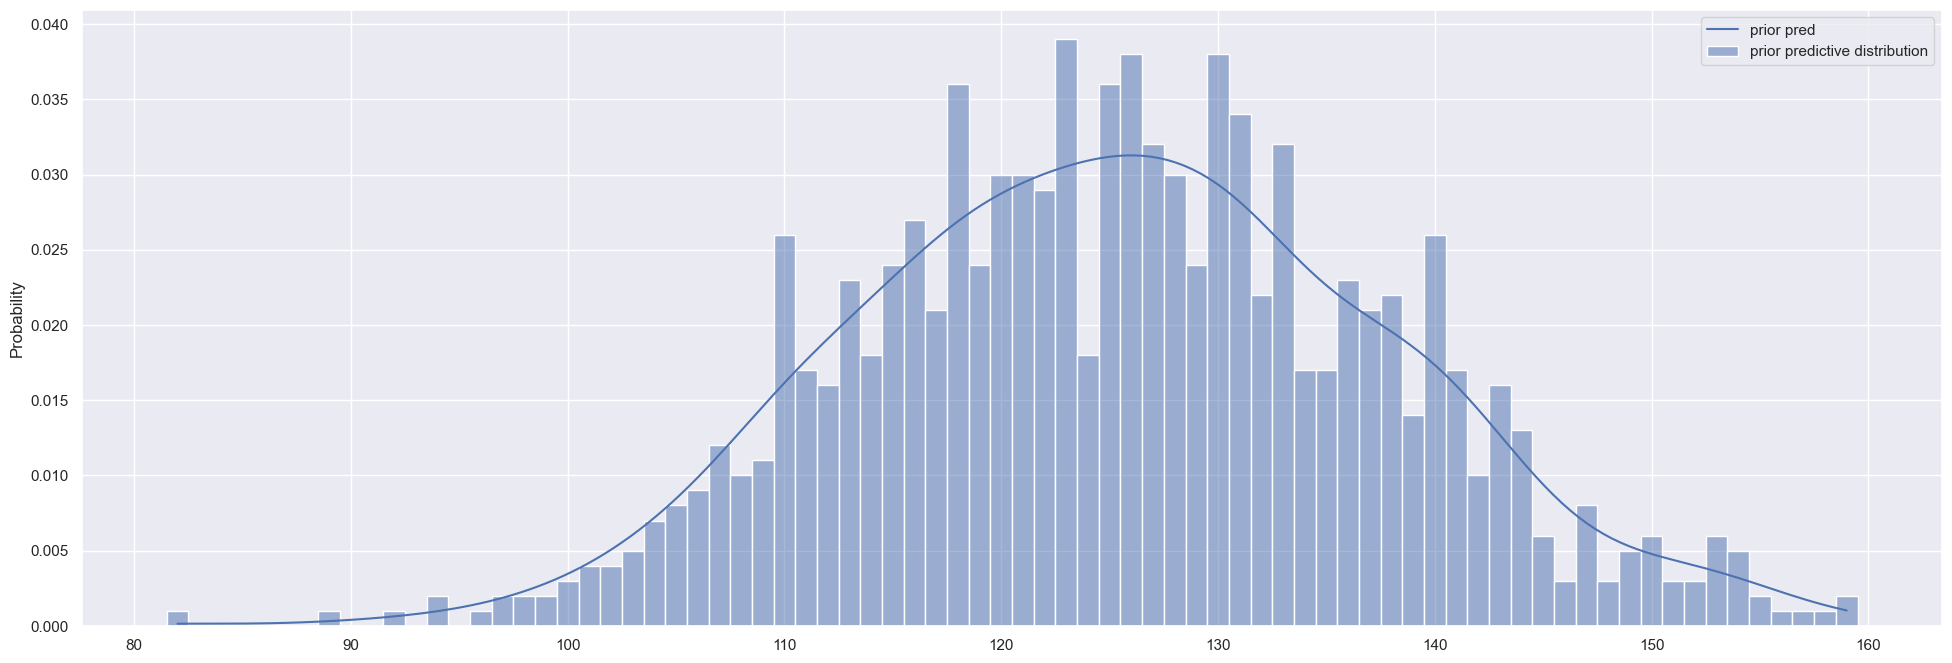

In [21]:
plot_prior_predictive(trace2)

### Posterior

Let's put a new information - `k` successes in the experiment.

In [22]:
k = 140 # heads number to estimate the posterior predicted distribution

In [23]:
model3, trace3 = coin_model(a, b, n, SEED, to_sample = "posterior", observed = k)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 181 seconds.


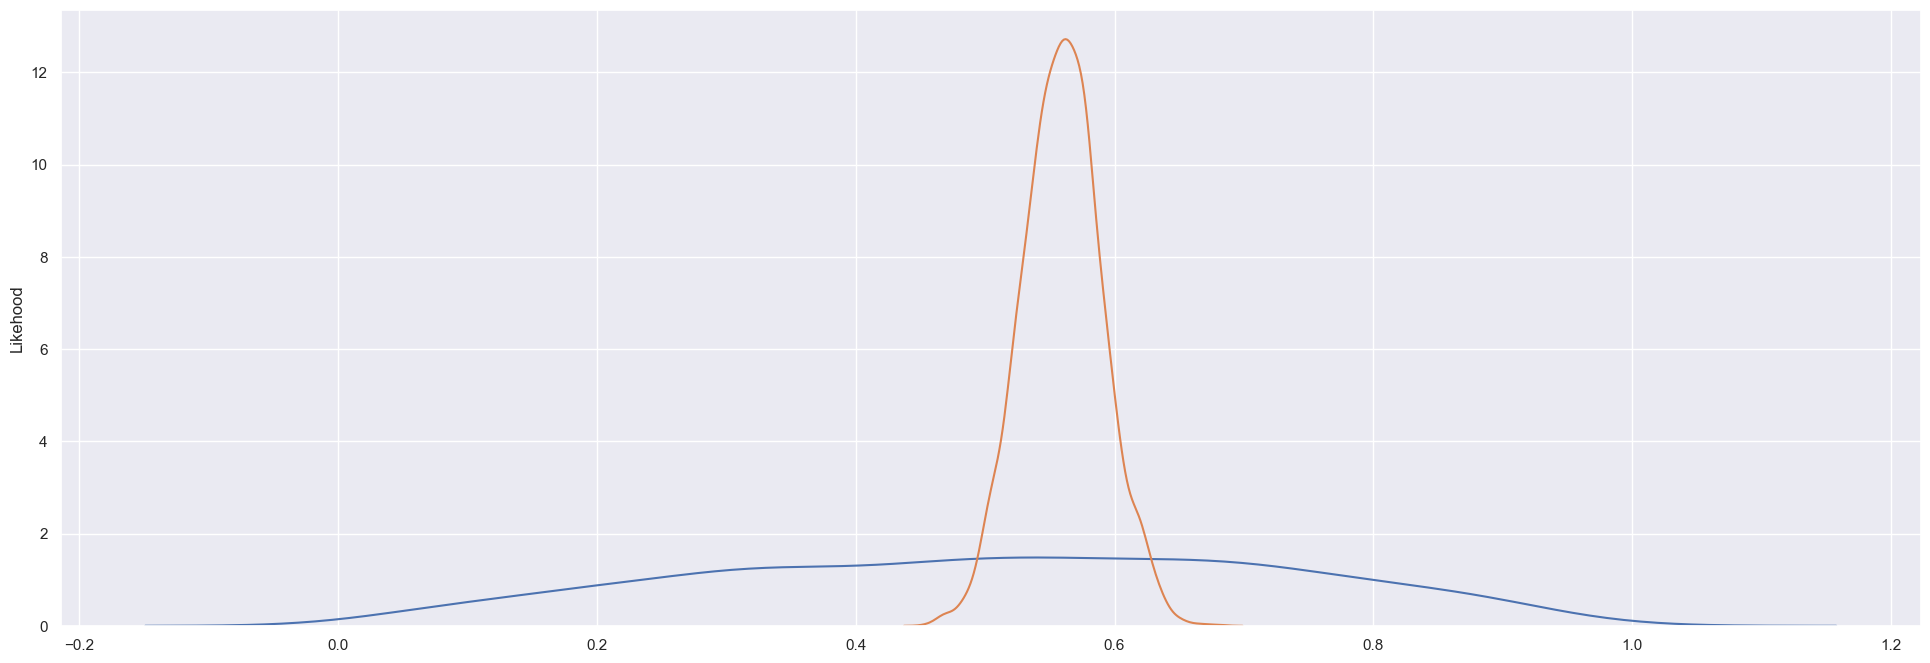

In [24]:
plot_prior(trace1, "prior")
plot_prior(trace3, "posterior")

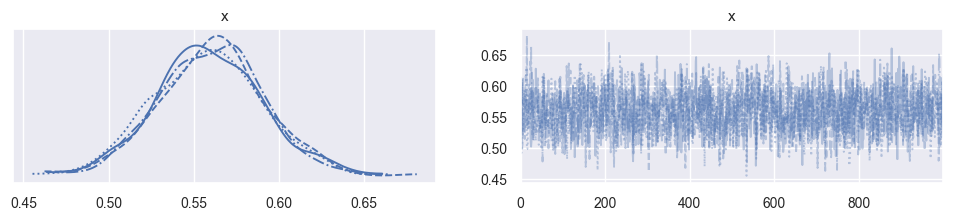

In [25]:
# Plot distribution (histogram or kernel density estimates) and sampled values from MCMC
with model3:
    az.plot_trace(trace3)

1. On the left plot all chains (different lines) looks closer to each other. Therefore the model is more-less stable.   
2. On the right side trace plots: there is no trend or pattern to the time series of sampled values. Therefore MCMC is converged.

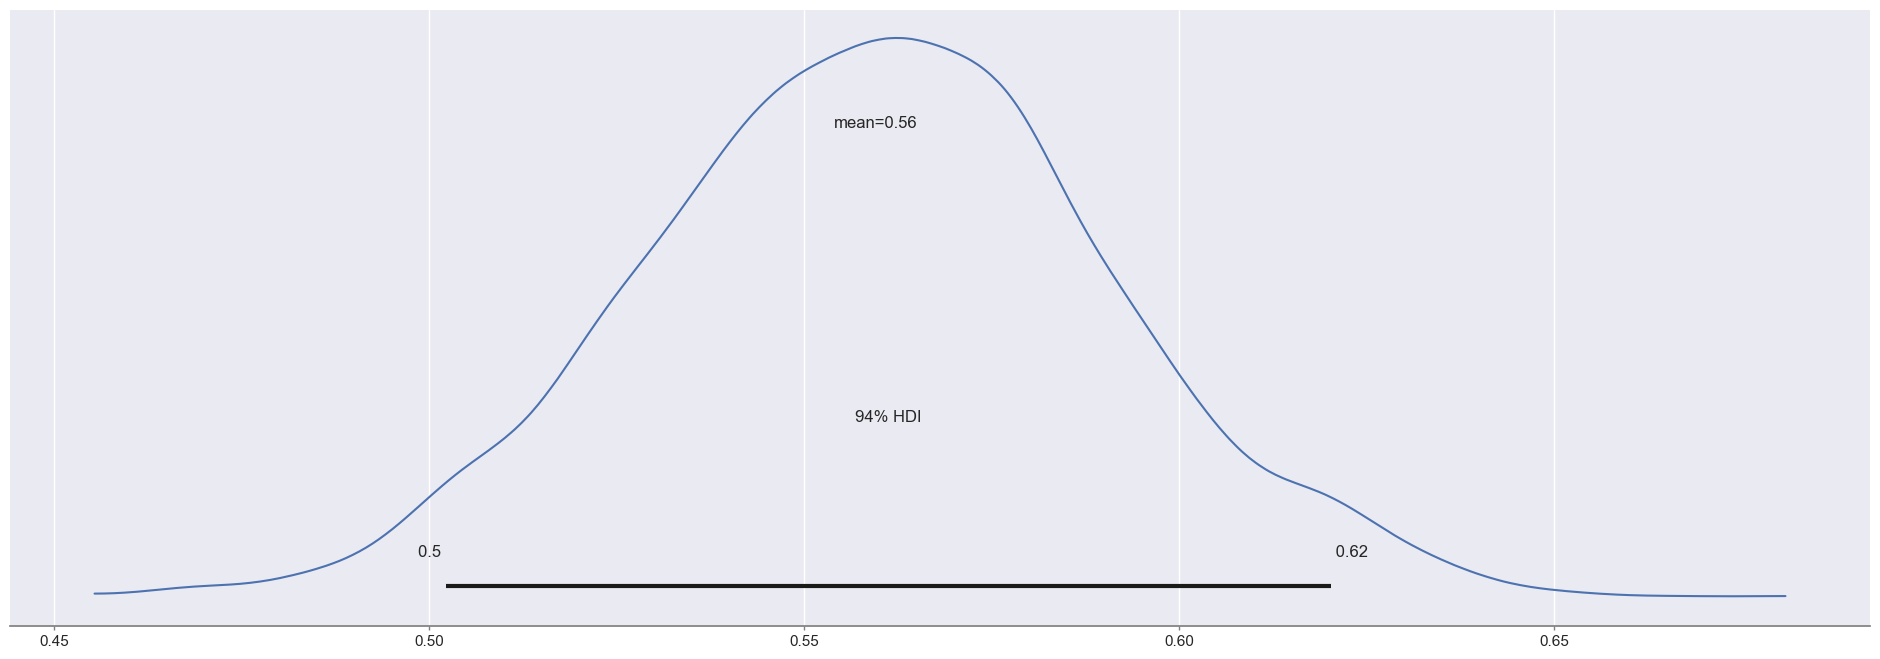

In [26]:
with model3:
    az.plot_posterior(trace3)
    
plt.title('');

When `k=140` prior distribution chnges, `p=0,56` and actual `p` is in `0,5-0,62` range with probability `94%`. 

### Posterior predictive

Sampling: [k]


c:\Users\parshin_sa2\Miniconda3\envs\otus-mcmc\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\parshin_sa2\Miniconda3\envs\otus-mcmc\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\parshin_sa2\Miniconda3\envs\otus-mcmc\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\parshin_sa2\Miniconda3\envs\otus-mcmc\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

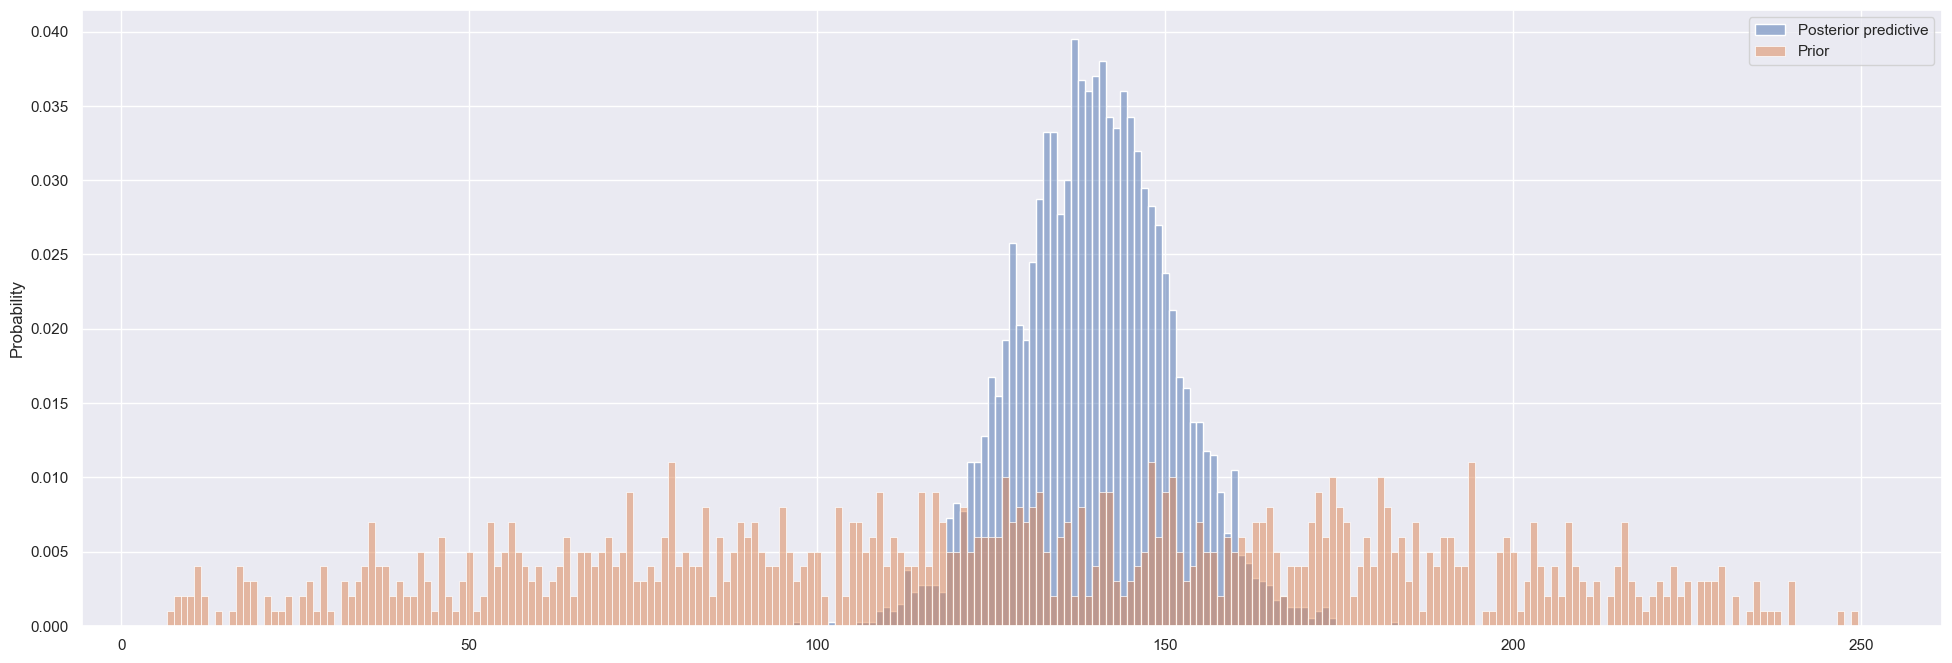

In [153]:
with model3:
    post_pred_3 = pm.sample_posterior_predictive(trace3, random_seed=SEED)
    
sns.histplot(post_pred_3.to_dict()['posterior_predictive']['k'].flatten(), stat='probability', discrete=True, alpha=0.5, label="Posterior predictive");
sns.histplot(trace1.to_dict()['prior']['k'].flatten(), stat='probability', discrete=True, alpha=0.5, label="Prior");
plt.legend()

The information about heads results (`k`) 140 times during 250 throws dramatically change the distribution (makes narrower).

### Several observations (experiment with different successes and experiments)

In [165]:
model4, trace4 = coin_model(a, b, n, SEED, to_sample = "posterior", observed = [140, 220])
model5, trace5 = coin_model(a, b, n, SEED, to_sample = "posterior", observed = [100, 120])
model6, trace6 = coin_model(a, b, n, SEED, to_sample = "posterior", observed = [125, 125,])
model7, trace7 = coin_model(a, b, n, SEED, to_sample = "posterior", observed = [125, 125, 125, 125, 125, 125])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


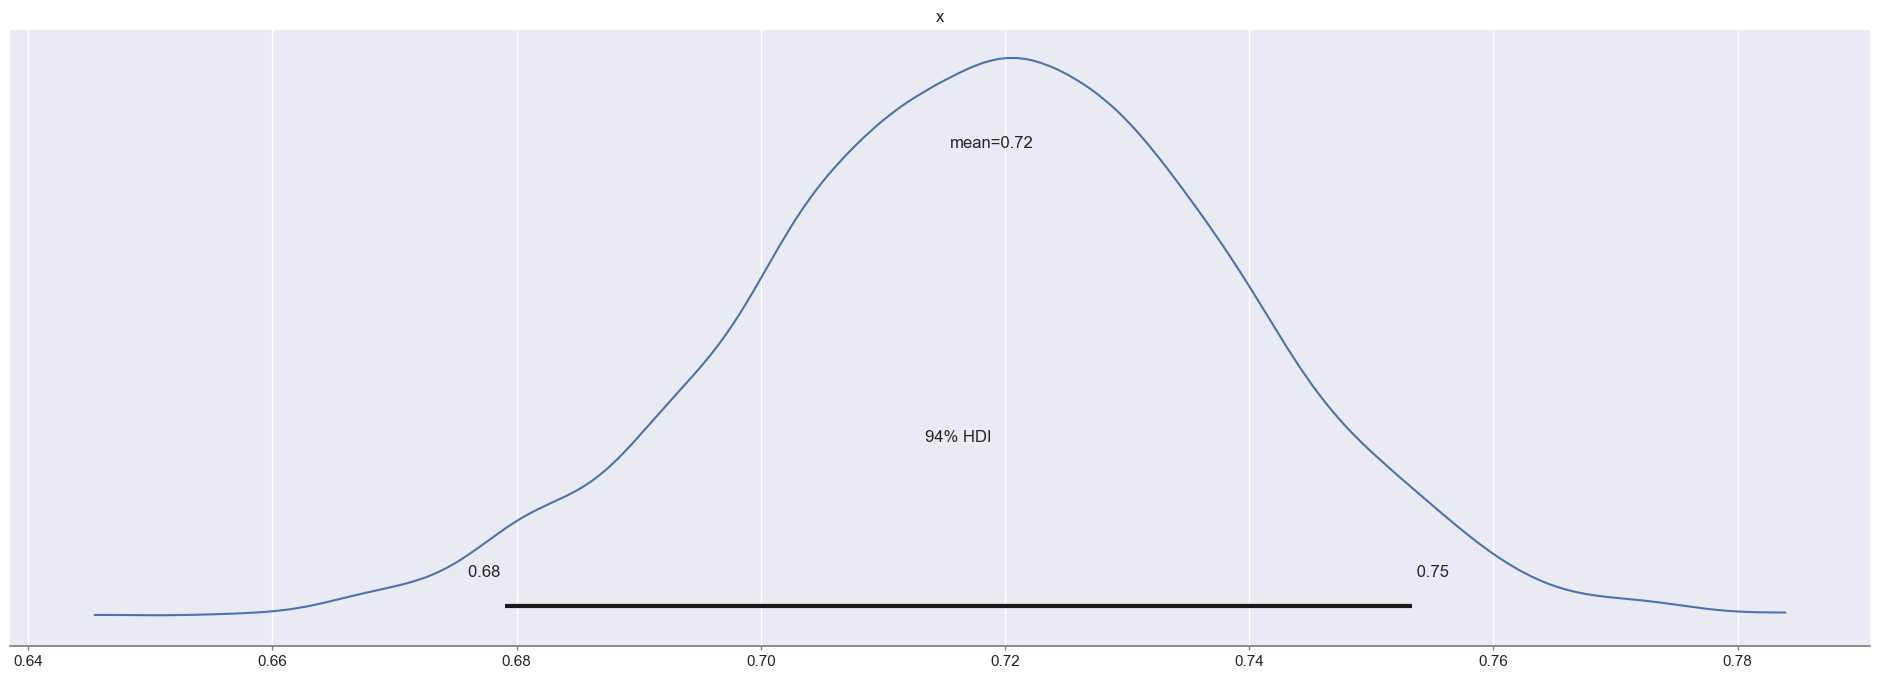

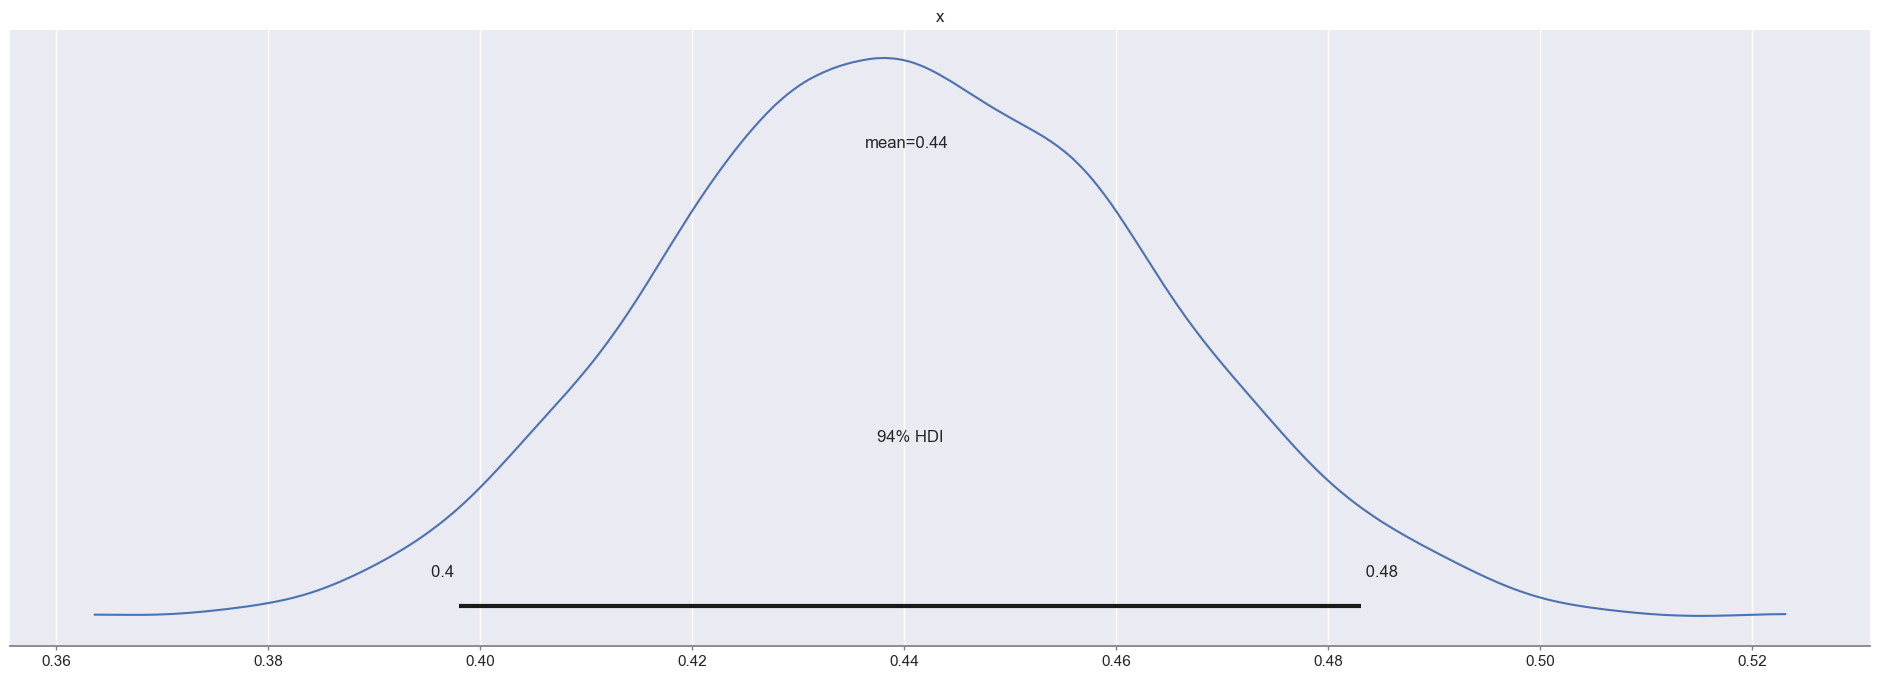

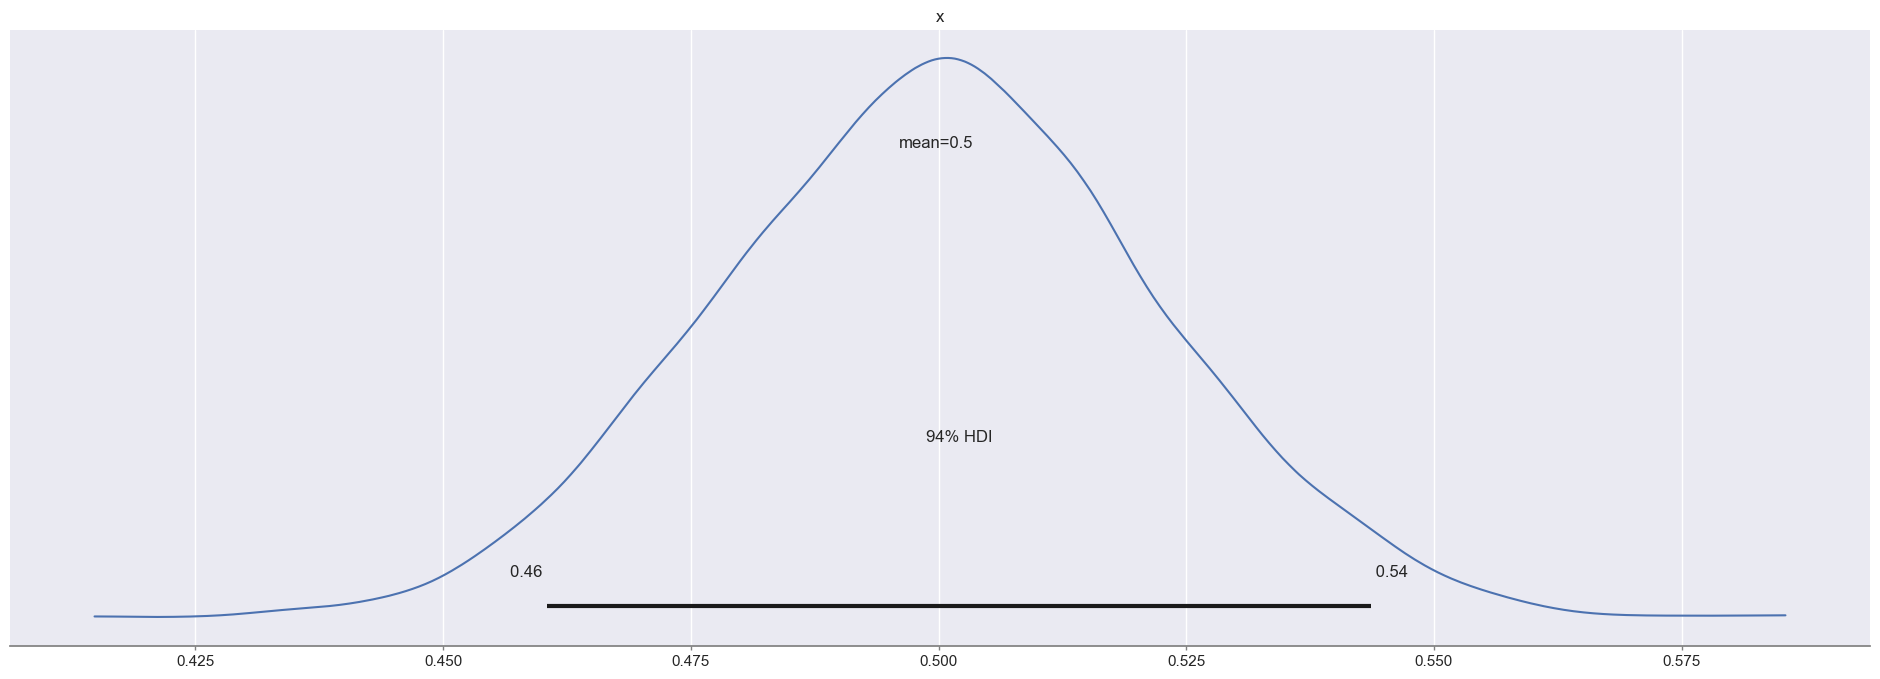

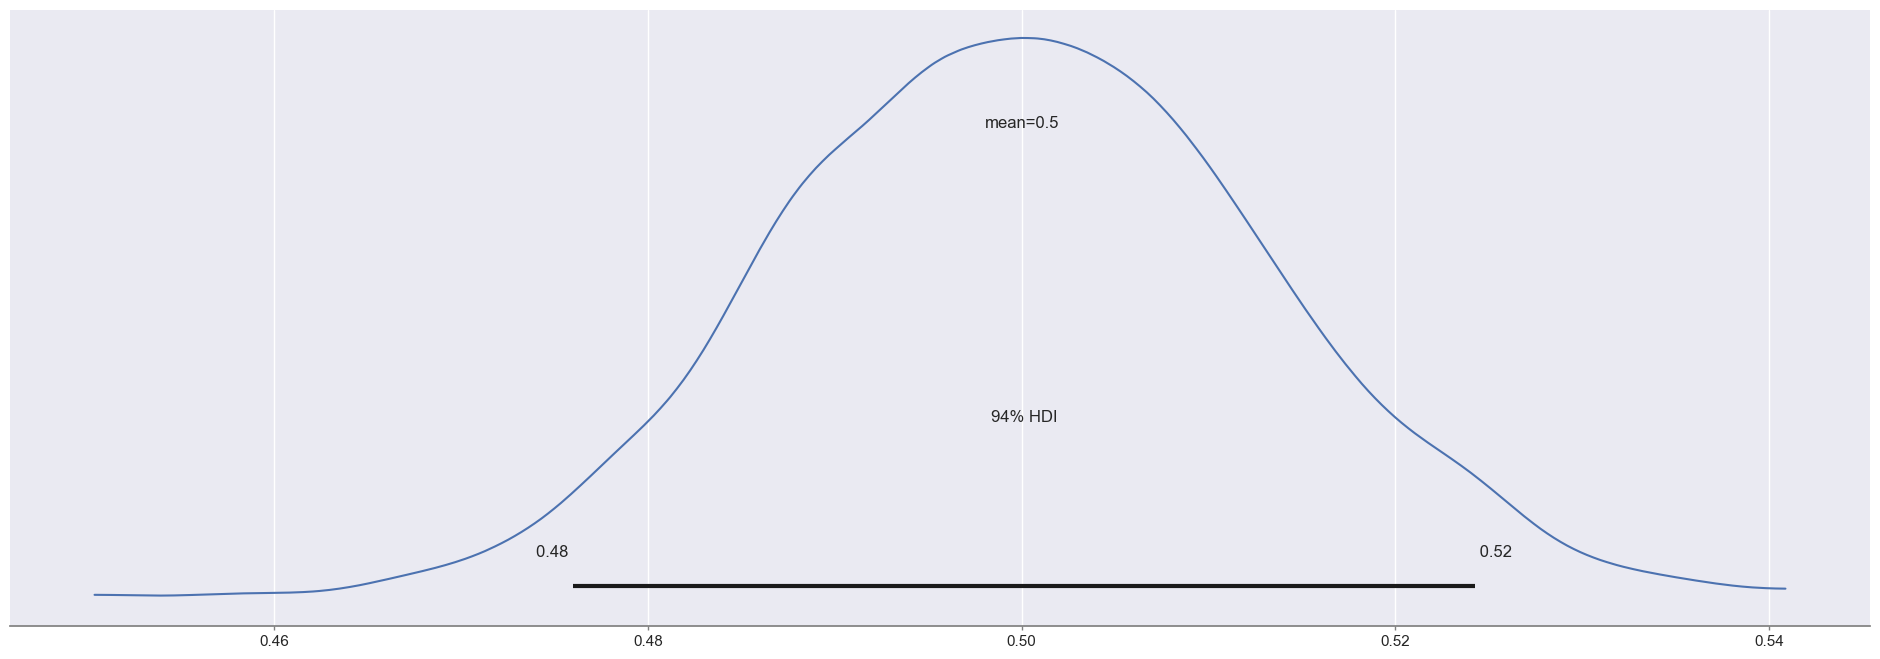

In [166]:
with model4:
    az.plot_posterior(trace4)
with model5:
    az.plot_posterior(trace5)
with model6:
    az.plot_posterior(trace6)
with model7:
    az.plot_posterior(trace7)

plt.title('');

Sampling: [k]


Sampling: [k]


Sampling: [k]


Sampling: [k]


c:\Users\parshin_sa2\Miniconda3\envs\otus-mcmc\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\parshin_sa2\Miniconda3\envs\otus-mcmc\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\parshin_sa2\Miniconda3\envs\otus-mcmc\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\parshin_sa2\Miniconda3\envs\otus-mcmc\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

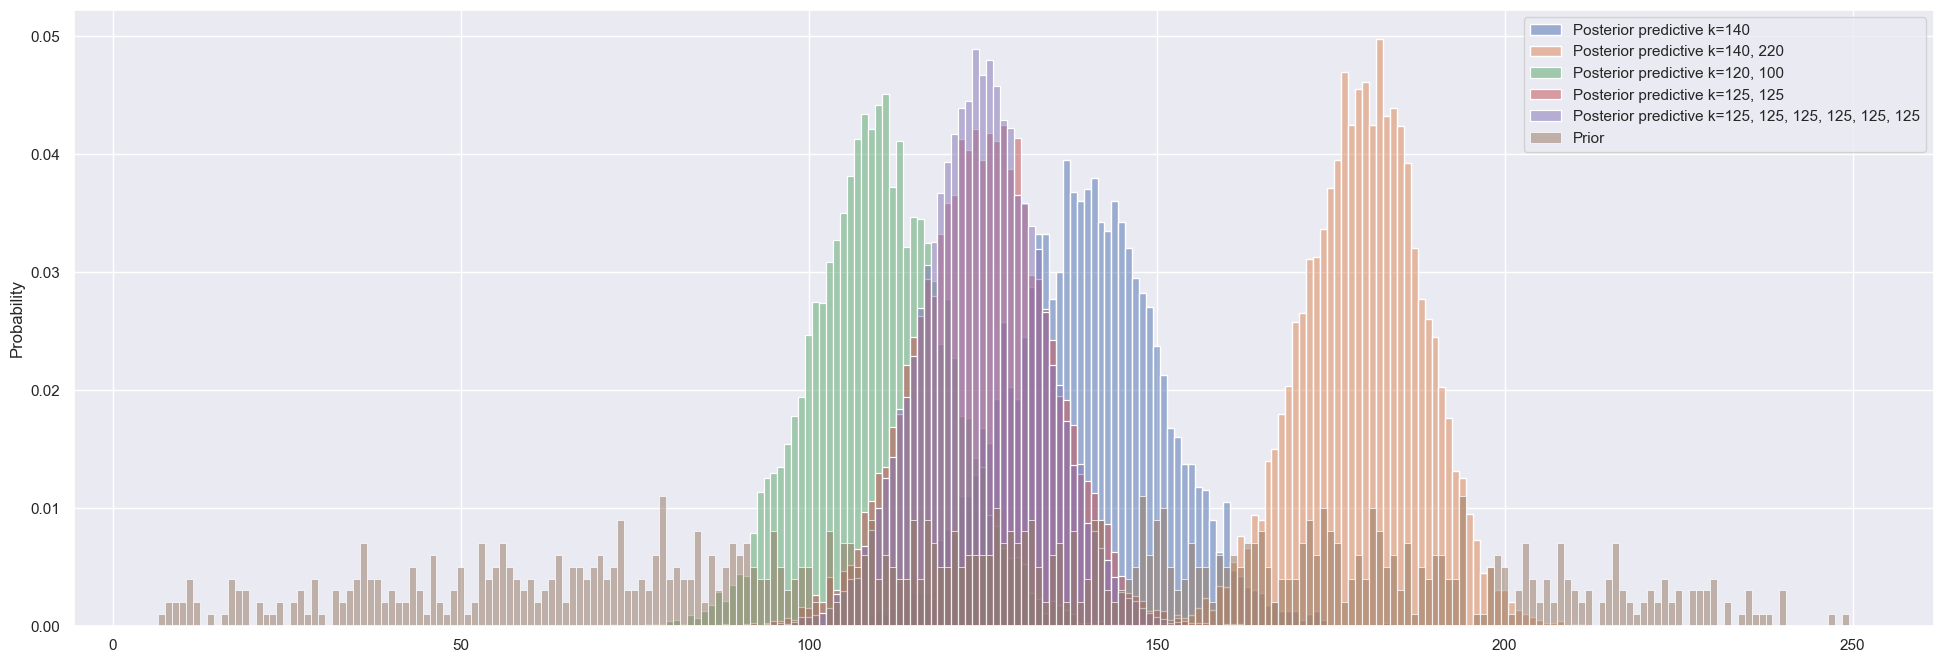

In [167]:
with model4:
    post_pred_4 = pm.sample_posterior_predictive(trace4, random_seed=SEED)
with model5:
    post_pred_5 = pm.sample_posterior_predictive(trace5, random_seed=SEED)
with model6:
    post_pred_6 = pm.sample_posterior_predictive(trace6, random_seed=SEED)
with model7:
    post_pred_7 = pm.sample_posterior_predictive(trace7, random_seed=SEED)
    
sns.histplot(post_pred_3.to_dict()['posterior_predictive']['k'].flatten(), stat='probability', discrete=True, alpha=0.5, label="Posterior predictive k=140");
sns.histplot(post_pred_4.to_dict()['posterior_predictive']['k'].flatten(), stat='probability', discrete=True, alpha=0.5, label="Posterior predictive k=140, 220");
sns.histplot(post_pred_5.to_dict()['posterior_predictive']['k'].flatten(), stat='probability', discrete=True, alpha=0.5, label="Posterior predictive k=120, 100");
sns.histplot(post_pred_6.to_dict()['posterior_predictive']['k'].flatten(), stat='probability', discrete=True, alpha=0.5, label="Posterior predictive k=125, 125");
sns.histplot(post_pred_7.to_dict()['posterior_predictive']['k'].flatten(), stat='probability', discrete=True, alpha=0.5, label="Posterior predictive k=125, 125, 125, 125, 125, 125");
sns.histplot(trace1.to_dict()['prior']['k'].flatten(), stat='probability', discrete=True, alpha=0.5, label="Prior");
plt.legend()

Observed:
1. At least one observed value of successes greatly reduces the spread of the probability distribution of heads.
2. For several significant deviations from the prior mean of heads, the probability of getting heads shifts noticeably.
3. As the observation number of the same heads number increases, the distribution does not change much. Although the HDI in the posterior distribution differs significantly: (0.46; 0.54) versus (0.48; 0.52).